In [12]:
import numpy as np 
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size':15,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})

from astropy.io import fits
from astropy.table import Table

# Quick start: getting binned median residuals, corrected ASCAP residuals
## Choose a star to play with
[CA_clean.fits](https://drive.google.com/file/d/14ydyGc6Z4UMmEaRLRCIwrhmYJsGAwpwK/view?usp=sharing) is a subset of `allStarLite-dr17-synspec_rev1.fits` containing stars towards the California Cloud with non-NaN `TEFF`, `LOGG`, and `M_H` values. To show how to access and use our binned median residuals to clean stellar residuals, we will choose a star from this table, get the corresponding `aspcapStar` file ([also available here](https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/apo25m/CA_162-11_btx/aspcapStar-dr17-2M04101642+3535373.fits)), and then correct its ASPCAP residual with our median residual.

In [2]:
CA_clean = Table(fits.open('CA_clean.fits')[1].data)
star = CA_clean[51] # feel free to choose other stars

print('APOGEE_ID', star['APOGEE_ID'])
print('TEFF', star['TEFF'], 'LOGG', star['LOGG'], 'M_H', star['M_H'], '\n')

aspcap_url = 'https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TSCOPE}/{FIELD}/aspcapStar-dr17-{ID}.fits'.format(
                TSCOPE = star['TELESCOPE'], FIELD = star['FIELD'], ID = star['APOGEE_ID'])

print('Download to your working directory:')
print(aspcap_url)

APOGEE_ID 2M04101642+3535373
TEFF 4725.0117 LOGG 2.5071473 M_H -0.14092 

Download to your working directory:
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/apo25m/CA_162-11_btx/aspcapStar-dr17-2M04101642+3535373.fits


In [3]:
aspcap = fits.open('aspcapStar-dr17-2M04101642+3535373.fits')

## Accessing binned median residuals 
You can download the catalog of median residuals files [here](https://drive.google.com/file/d/1Xi9358vslHVCtdlQfjuPhUOtfC0u-0WP/view?usp=sharing). The data structure for each is 

|  HDU  | Contents |
| -- | -- | 
| 0 | `PrimaryHDU`, no data|
| 1 | Median binned residual |
| 2 | Mean binned residual |
| 3 | Standard deviation |
| 4 | Median absolute deviation |
| 5 | 16th percentile |
| 6 | 84th percentile |
| 7 | N stars / pixel |

and a table of metadata for each parameter bin is described in `meta.fits`:

| 'TEFF_MIN' | 'TEFF_MAX' | 'LOGG_MIN' | 'LOGG_MAX' | 'M_H_MIN'| 'M_H_MAX' |'NBIN' | 'STDEV_MEDIAN' |'STDEV_MEAN' | 'FNAME'| 
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| TEFF bin boundaries | | LOGG bin boundaries | | M_H bin boundaries | |  stars in bin |  median standard deviation of HDU[1] | mean standard deviation of HDU[1] | filename |  

For a set of `TEFF`, `LOGG`, and `M_H` parameters, the path to the appropriate binned median residual file can be selected from `meta.fits` using the following `get_medres()` function. If you prefer not to download the whole .zip file, the example star chosen for this notebook corresponds to [TEFFBIN4700_4750_LOGGBIN2.4_2.6_M_HBIN-0.3_-0.1.fits](https://drive.google.com/file/d/1wbDUCGUWvXQrTFKQIFM6oWwvbmhMxwL6/view?usp=sharing).

In [9]:
meta = Table(fits.open('Residuals/meta.fits')[1].data)

def get_medres(teff, logg, m_h, medres_dir = 'Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['TEFF_MIN'], teff < meta['TEFF_MAX'], 
                    logg >= meta['LOGG_MIN'], logg < meta['LOGG_MAX'],
                   m_h >= meta['M_H_MIN'], m_h < meta['M_H_MAX']]))[0]
    
    row = meta[rowselect]
    filename = row['FNAME'].item()
    return medres_dir + filename


teff = star['TEFF'] # 4725.0117
logg = star['LOGG'] # 2.5071473
m_h = star['M_H'] # -0.14092

medres = fits.open(get_medres(teff, logg, m_h))

print('Stars in bin:', medres[0].header['NBIN'])

Stars in bin: 1939


## Applying binned median residuals to stellar data
ASPCAP stellar residuals can then be corrected by dividing out the median residual:

In [10]:
residual = aspcap[1].data / aspcap[3].data
median_residual = medres[1].data
corrected_residual = residual / median_residual

/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_45682/1260263165.py:1: RuntimeWarning: invalid value encountered in true_divide
  residual = aspcap[1].data / aspcap[3].data


Plotting the corrected and uncorrected residuals together for a narrow wavelength window surrounding the DIB, the binned median residual helps clean up leftover features in the stellar residual:

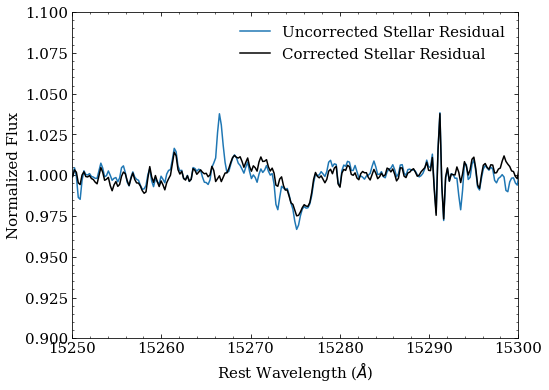

In [13]:
# Display ASPCAP residual with and without correction by our median residual
dib_position = 15272.42 # in the 
wavs = np.power(10, 4.179 + 6e-06 * np.arange(8575)) 


fig, ax = plt.subplots(figsize = (8,6))

ax.plot(wavs, residual, label = 'Uncorrected Stellar Residual', c = 'C0')
ax.plot(wavs, corrected_residual, label = 'Corrected Stellar Residual', c = 'k')

ax.set_xlim(15250, 15300)

ax.set_ylim(0.9, 1.1)
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(frameon = False)

plt.show()

### Notes for ease of use
+ Bins with small numbers of stars have not been excluded, so consider using `meta.fits` to filter bin sizes below a certain threshold, e.g.  `NBIN < 5`.
+ Completely empty bins will have `hdu.data = None`.